In [ ]:
# random forest for comparison, this tells us that maybe DNN is not the best model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest R²: 0.9233577682525691


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('../datasets/MEGAFRAME_CLEANEDV2.csv')

# Remove both targets and irrelevant columns from features
X = df.drop(columns=['Gini index', 'UNEMP', 'Reference area', 'REF_AREA', 'Region'])
y = df['Gini index']

categorical_features = ['TIME_PERIOD']
numerical_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
# Chat GPT gave me the idea to do droupout layers, the lower I used the better the model performed
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=300, batch_size=8, validation_split=0.1, callbacks=[early_stop])

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")

new_data = pd.DataFrame({
    'TIME_PERIOD': [2001],
    'Trade union density': [78.699997],
    'Combined corporate income tax rate': [28.0],
    'Education spending': [0.0734319847255705],
    'Health spending': [0.0631525528524754],
    'Housing spending': [0.0057497428086187],
    'Community development spending': [0.0025634702523358],
    'IRLT': [5.1075],
    'Population, total': [8895960.0],
    'GDP per capita (current US$)': [27259.4806735435],
    'Inflation, consumer prices (annual %)': [2.40595834145438]
})

new_data_processed = preprocessor.transform(new_data)
predicted_gini = model.predict(new_data_processed)
print(f"Predicted Gini: {predicted_gini.flatten()[0]:.2f}")


Epoch 1/300


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 940.8663 - mae: 30.1803 - val_loss: 954.1045 - val_mae: 30.6802
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 851.8884 - mae: 28.6689 - val_loss: 878.9827 - val_mae: 29.4452
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 708.5175 - mae: 26.0839 - val_loss: 741.2808 - val_mae: 26.9710
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 561.8658 - mae: 22.8130 - val_loss: 541.4696 - val_mae: 22.7405
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 380.0973 - mae: 18.1351 - val_loss: 321.9977 - val_mae: 16.9240
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 234.8989 - mae: 13.4394 - val_loss: 135.0238 - val_mae: 9.4528
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 139.0978 - mae: 9.7321 - val_loss: 64.8766 - val_mae: 6.0992
Epoch 8/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75.4288 - mae: 7.0228 - val_loss: 33.4038 - val_mae: 4.5946
Epoch 9/300
36/36 ━━━━━━━━━━━━━━━━━

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MAE: 2.23
MSE: 10.81
RMSE: 3.29
R² Score: 0.69


In [53]:
from sklearn.metrics import mean_absolute_error, r2_score

mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_processed):
    X_train, X_val = X_processed[train_index], X_processed[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    
    y_val_pred = model.predict(X_val).flatten()
    
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"Mean MAE over 5 folds: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"Mean R² over 5 folds: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Mean MAE over 5 folds: 1.93 ± 0.16
Mean R² over 5 folds: 0.7293 ± 0.0907


In [ ]:
print("Summary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)


Summary Statistics:
       TIME_PERIOD  Trade union density  Combined corporate income tax rate  \
count   400.000000           400.000000                          400.000000   
mean   2010.605000            32.947000                           25.384909   
std       5.088094            21.854253                            6.892238   
min    2000.000000             7.100000                            9.000000   
25%    2006.750000            16.600000                           20.000000   
50%    2011.000000            25.050000                           25.000000   
75%    2015.000000            49.825000                           30.000000   
max    2020.000000            91.599998                           51.611553   

       Education spending  Health spending  Housing spending  \
count          400.000000       400.000000        400.000000   
mean             0.052006         0.064127          0.003168   
std              0.014906         0.017721          0.003309   
min         

In [64]:
weights = model.get_weights()

# Each item in `weights` is either a weight matrix or bias vector for a layer
for i, w in enumerate(weights):
    print(f"Weight {i} shape: {w.shape}")
    print(w[:5])  # show the first 5 values (or rows if 2D)

Weight 0 shape: (31, 128)
[[ 4.00353372e-02 -4.89444397e-02  3.21174855e-03 -2.06976771e-01
  -1.77904516e-01 -1.99724928e-01 -1.93760663e-01  1.68917254e-01
   1.35592550e-01  7.11843893e-02  1.33314267e-01  1.33903772e-01
  -1.88693717e-01  2.25412801e-01 -4.12906893e-02 -1.93315282e-01
   2.24756431e-02  6.94499761e-02 -9.08202156e-02 -1.63324729e-01
   1.03880845e-01  7.44698644e-02 -3.48716043e-02 -7.09798858e-02
  -4.96270694e-02 -1.75219685e-01 -4.19567414e-02 -5.14569245e-02
  -2.20649287e-01 -1.68454811e-01 -3.21014151e-02 -9.35234651e-02
   1.46608889e-01  5.80590367e-02 -1.33556304e-02  2.00247943e-01
   4.92242351e-03  1.35668591e-01 -1.53251693e-01 -5.49108200e-02
  -1.29620790e-01  3.67945991e-02 -1.72417790e-01 -7.18517005e-02
   5.96208870e-02  7.58613124e-02 -7.45347962e-02 -7.64463246e-02
  -8.57527107e-02  1.52691662e-01 -1.38089865e-01 -9.17177945e-02
   3.97566669e-02  1.36668514e-02 -2.00625420e-01  9.80460197e-02
  -1.96531758e-01 -1.13512523e-01  4.17773239e-02 

### ABOVE WAS THE GINI INDEX BEING PREDICTED, THE MODEL PERFORMS BETTER THAN LOGISTIC AND LINEAR

In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('../datasets/MEGAFRAME_CLEANEDV2.csv')

X = df.drop(columns=['UNEMP', 'Reference area', 'REF_AREA', 'TIME_PERIOD'])
y = df['UNEMP']

categorical_features = ['Region']
numerical_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.02),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.02),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=300, batch_size=8, validation_split=0.1, callbacks=[early_stop])

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE (Unemployment): {mae:.2f}")

new_data = pd.DataFrame({
    'Region': ['Europe and Central Asia'],  
    'Trade union density': [78.699997],
    'Combined corporate income tax rate': [28.0],
    'Education spending': [0.0734319847255705],
    'Health spending': [0.0631525528524754],
    'Housing spending': [0.0057497428086187],
    'Community development spending': [0.0025634702523358],
    'IRLT': [5.1075],
    'Population, total': [8895960.0],
    'GDP per capita (current US$)': [27259.4806735435],
    'Inflation, consumer prices (annual %)': [2.40595834145438],
    'Gini index': [26.5]
})

new_data_processed = preprocessor.transform(new_data)

predicted_unemp = model.predict(new_data_processed)
print(f"Predicted Unemployment: {predicted_unemp.flatten()[0]:.2f}")


Epoch 1/300


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 58.4354 - mae: 6.3080 - val_loss: 55.8366 - val_mae: 6.3160
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37.4434 - mae: 4.7737 - val_loss: 43.4969 - val_mae: 5.4484
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.4705 - mae: 3.2056 - val_loss: 30.9263 - val_mae: 4.3333
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.9029 - mae: 2.9179 - val_loss: 22.1314 - val_mae: 3.3644
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.8261 - mae: 2.4360 - val_loss: 15.9456 - val_mae: 2.7560
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6557 - mae: 2.2217 - val_loss: 12.6280 - val_mae: 2.3691
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.4873 - mae: 2.6126 - val_loss: 11.7230 - val_mae: 2.2662
Epoch 8/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0834 - mae: 2.2153 - val_loss: 9.1934 - val_mae: 2.0003
Epoch 9/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0

In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
MAE: 1.52
MSE: 6.87
RMSE: 2.62
R² Score: 0.56


In [139]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('../datasets/MEGAFRAME_CLEANEDV2.csv')

X = df.drop(columns=['UNEMP', 'Reference area', 'REF_AREA', 'TIME_PERIOD'])
y = df['UNEMP']

categorical_features = ['Region']
numerical_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

X_processed = preprocessor.fit_transform(X)

model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_processed.shape[1],)),
    BatchNormalization(),
    Dropout(0.02),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.02),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_processed, y, epochs=300, batch_size=8, validation_split=0.1, callbacks=[early_stop])

# Since no test set is reserved, evaluation is on validation split only

new_data = pd.DataFrame({
    'Region': ['Europe and Central Asia'],  
    'Trade union density': [78.699997],
    'Combined corporate income tax rate': [28.0],
    'Education spending': [0.0734319847255705],
    'Health spending': [0.0631525528524754],
    'Housing spending': [0.0057497428086187],
    'Community development spending': [0.0025634702523358],
    'IRLT': [5.1075],
    'Population, total': [8895960.0],
    'GDP per capita (current US$)': [27259.4806735435],
    'Inflation, consumer prices (annual %)': [2.40595834145438],
    'Gini index': [26.5]
})

new_data_processed = preprocessor.transform(new_data)

predicted_unemp = model.predict(new_data_processed)
print(f"Predicted Unemployment: {predicted_unemp.flatten()[0]:.2f}")


Epoch 1/300


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 76.6880 - mae: 7.9476 - val_loss: 58.9476 - val_mae: 7.3589
Epoch 2/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.7323 - mae: 6.4471 - val_loss: 49.2968 - val_mae: 6.6569
Epoch 3/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.8826 - mae: 5.0298 - val_loss: 35.0742 - val_mae: 5.4242
Epoch 4/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.9230 - mae: 4.0017 - val_loss: 19.9204 - val_mae: 3.7861
Epoch 5/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.5963 - mae: 2.9879 - val_loss: 15.2876 - val_mae: 3.3429
Epoch 6/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.5375 - mae: 2.6019 - val_loss: 11.3195 - val_mae: 2.9650
Epoch 7/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7042 - mae: 2.1880 - val_loss: 7.0940 - val_mae: 2.3054
Epoch 8/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6999 - mae: 2.0651 - val_loss: 8.5879 - val_mae: 2.6297
Epoch 9/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.725

In [141]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the full dataset
y_pred = model.predict(X_processed)

# Calculate metrics
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"MAE (all data): {mae:.2f}")
print(f"MSE (all data): {mse:.2f}")
print(f"RMSE (all data): {rmse:.2f}")
print(f"R² Score (all data): {r2:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE (all data): 1.50
MSE (all data): 4.55
RMSE (all data): 2.13
R² Score (all data): 0.71


In [ ]:
import tensorflow as tf

model.save('Unemployment.keras')


In [ ]:
weights = model.get_weights()


for i, w in enumerate(weights):
    print(f"Weight {i} shape: {w.shape}")
    print(w[:5])  
    

Weight 0 shape: (15, 128)
[[-2.33480576e-02 -9.95766297e-02 -1.02199242e-02  1.00730091e-01
  -1.73726261e-01 -1.18276313e-01 -3.72197330e-02  8.62515345e-02
   2.00003818e-01  5.05676083e-02  1.07556768e-01 -3.26041952e-02
   1.78651601e-01  2.20159918e-01  7.56451562e-02  8.39277729e-02
  -1.43204033e-01 -9.78800878e-02  3.47562856e-03  1.96734220e-01
  -1.80745795e-01 -3.64378467e-02  1.24302000e-01 -1.10110275e-01
  -2.00446859e-01 -2.60999217e-03  1.25304922e-01 -1.30644679e-01
   1.86068192e-01 -1.59155324e-01 -2.70866230e-02 -7.74110556e-02
  -1.32602990e-01  1.44624278e-01 -1.39204443e-01  9.88116041e-02
   1.94318965e-01  1.02545395e-01 -7.96082169e-02 -1.98779050e-02
  -2.80431025e-02  3.51245292e-02 -7.98058137e-02  1.46404788e-01
   2.20207229e-01  1.21306613e-01 -5.06593287e-02  1.53024569e-01
   1.42624408e-01 -1.03598386e-01 -7.36124218e-02 -2.28505805e-02
   4.47406759e-03 -1.46161839e-01  1.50903627e-01 -1.84996411e-01
   3.11457482e-03 -7.39658102e-02  1.31006151e-01 

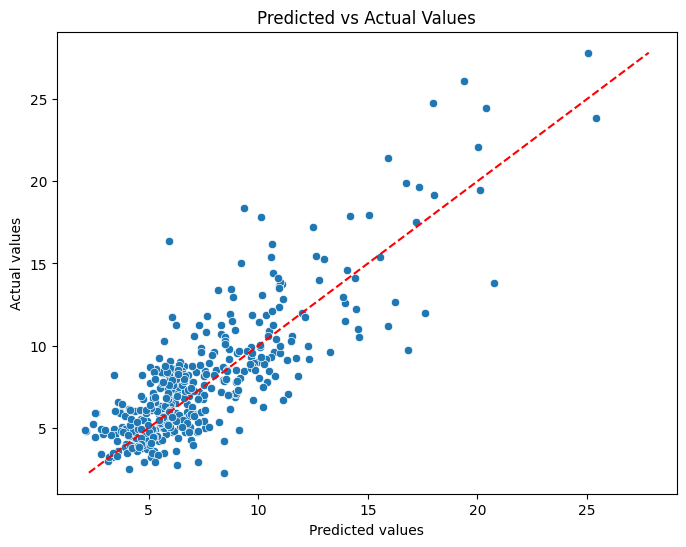

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Flatten predictions just in case
y_pred_flat = y_pred.flatten()
residuals = y - y_pred_flat
numerical_features = X.columns.difference(['Region'])
X_num = X[numerical_features] 
# 1) Predicted vs Actual scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_flat, y=y)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted vs Actual Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # reference line y=x
plt.show()


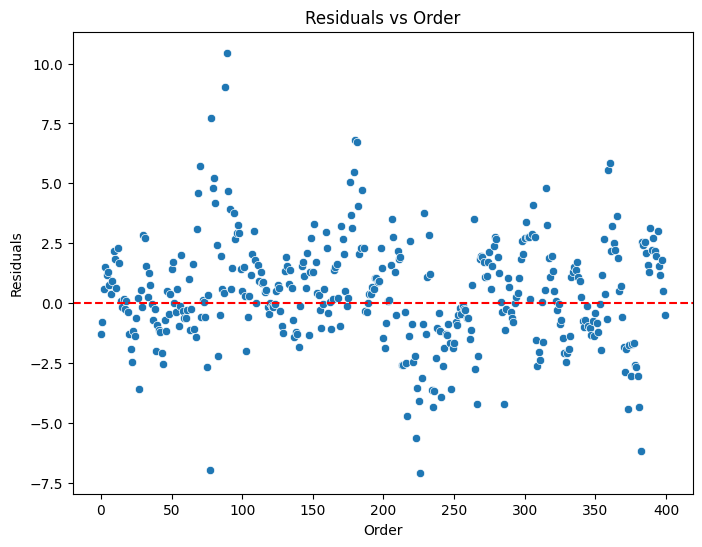

In [165]:
# 2) Residuals vs Order plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.arange(len(residuals)), y=residuals)
plt.xlabel('Order')
plt.ylabel('Residuals')
plt.title('Residuals vs Order')
plt.axhline(0, color='r', linestyle='--')
plt.show()

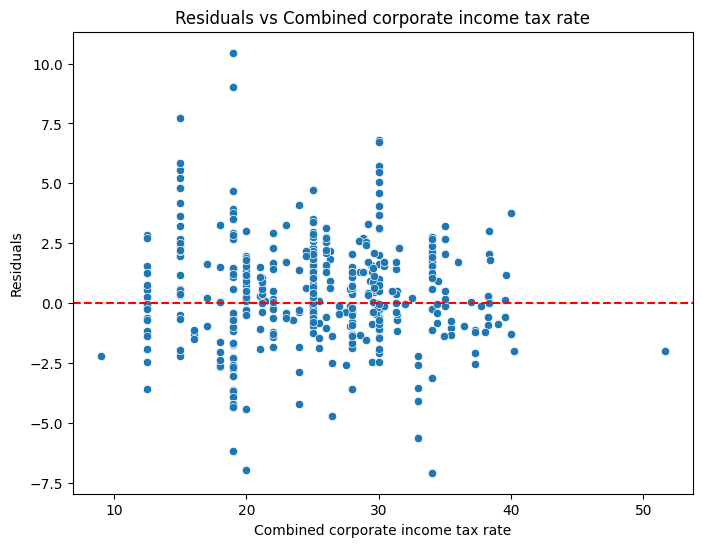

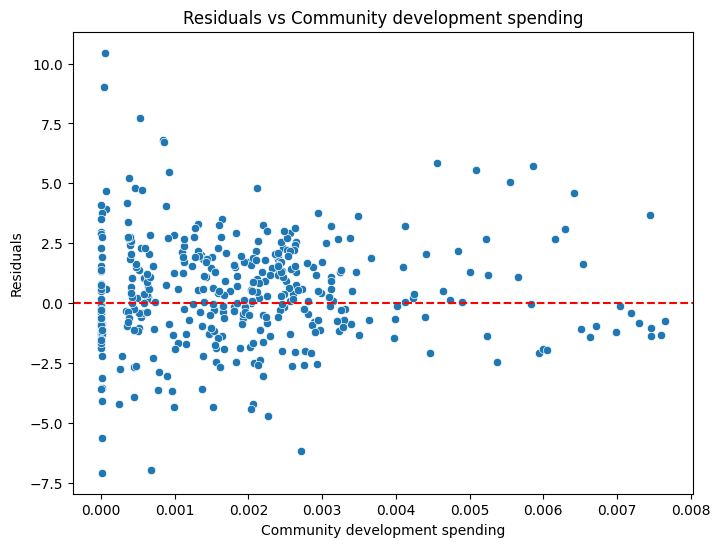

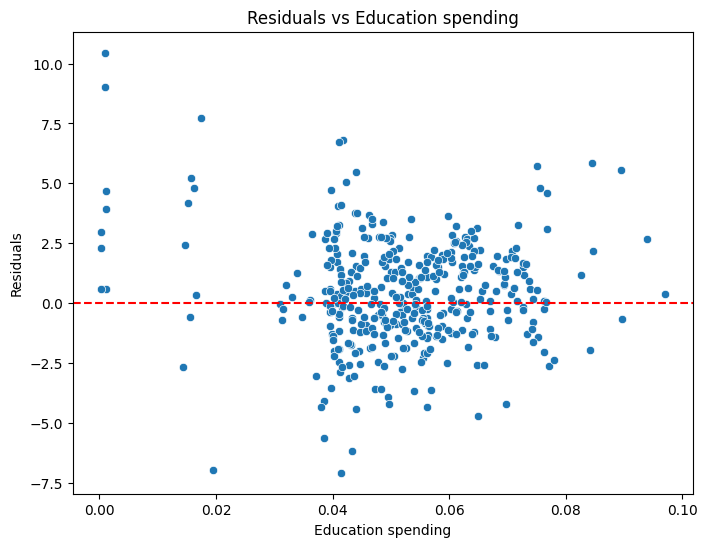

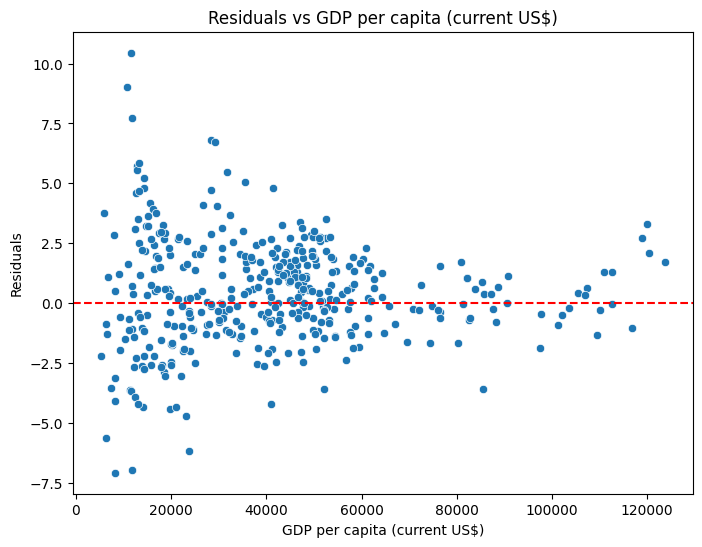

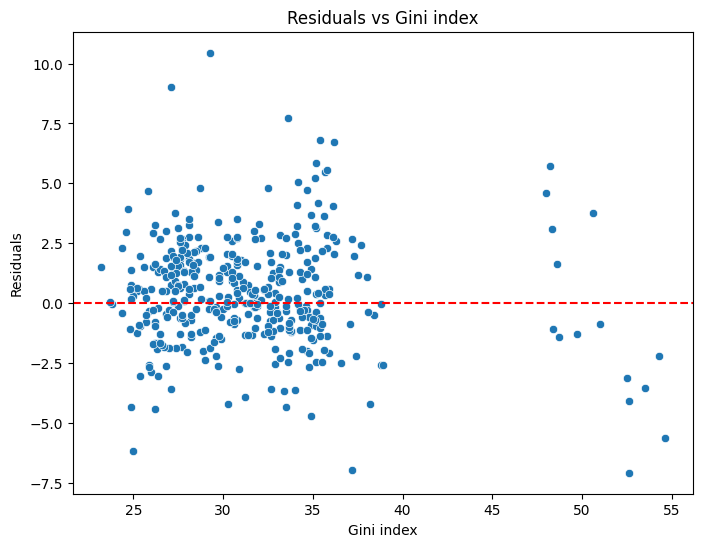

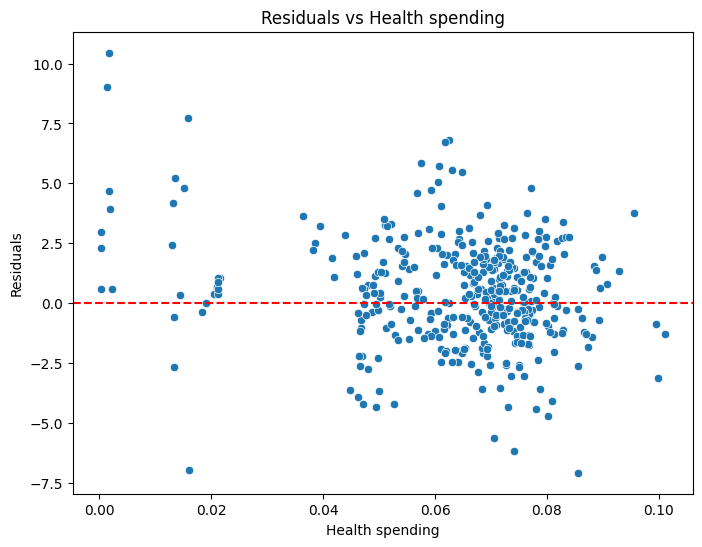

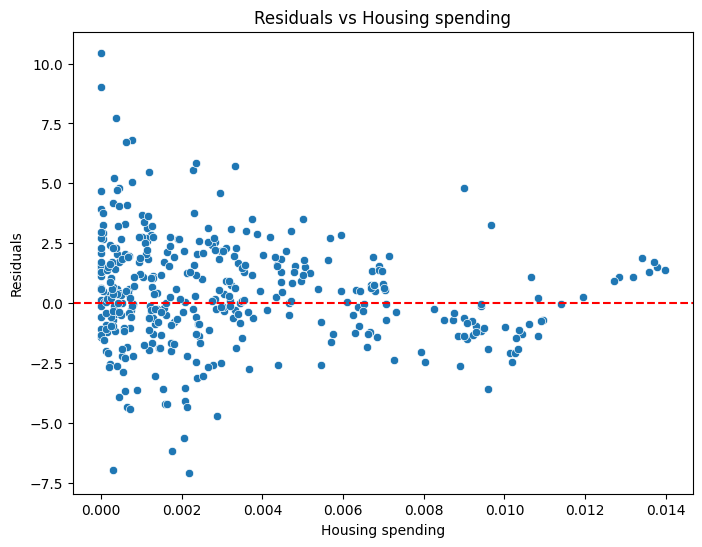

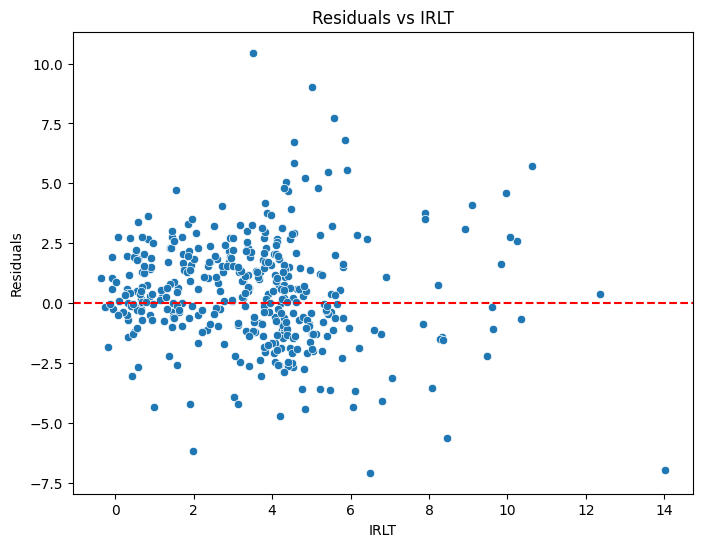

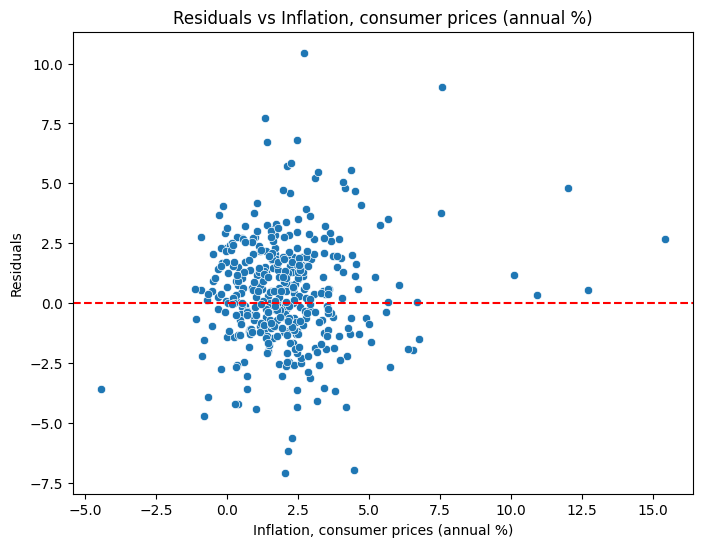

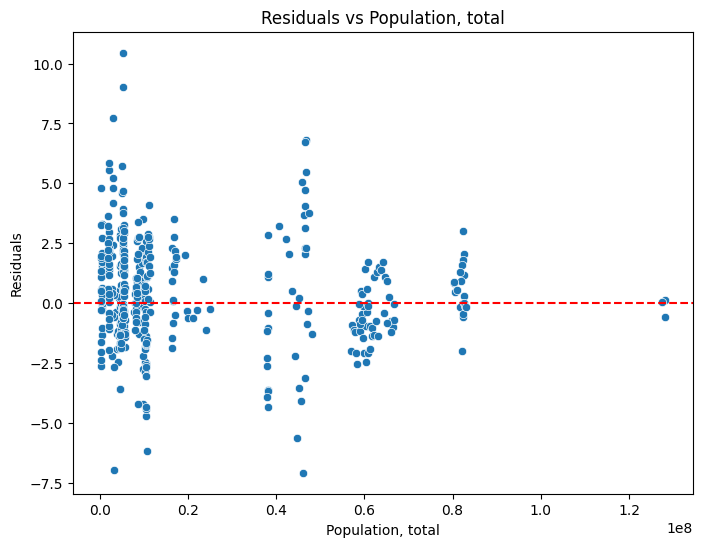

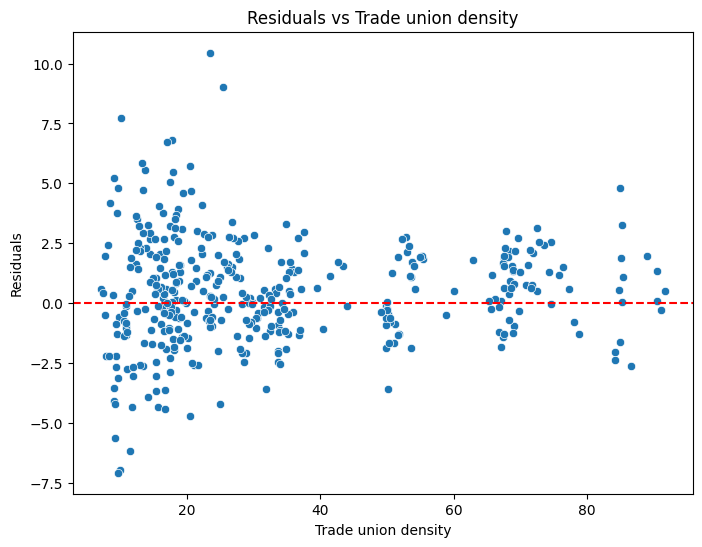

In [166]:

for col in numerical_features:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_num[col], y=residuals)
    plt.xlabel(col)
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs {col}')
    plt.axhline(0, color='r', linestyle='--')
    plt.show()

In [151]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Load dataset
df = pd.read_csv('../datasets/MEGAFRAME_CLEANEDV2.csv')
X = df.drop(columns=['UNEMP', 'Reference area', 'REF_AREA', 'TIME_PERIOD'])
y = df['UNEMP'].values  # Ensure it's a NumPy array

categorical_features = ['Region']
numerical_features = X.columns.difference(categorical_features)

# Model-building function
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.02),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.02),
        Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, mae_scores, r2_scores = [], [], []

for train_index, val_index in kf.split(X):
    # Split raw data
    X_train_raw, X_val_raw = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Preprocessing inside the fold
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])
    X_train = preprocessor.fit_transform(X_train_raw)
    X_val = preprocessor.transform(X_val_raw)

    # Build and train model
    model = build_model(X_train.shape[1])
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=300, batch_size=8, callbacks=[early_stop], verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_val).flatten()
    mse_scores.append(mean_squared_error(y_val, y_pred))
    mae_scores.append(mean_absolute_error(y_val, y_pred))
    r2_scores.append(r2_score(y_val, y_pred))

    K.clear_session()  # Clear session between folds

# Print final results
print(f"Average MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"Average MSE: {np.mean(mse_scores):.2f} ± {np.std(mse_scores):.2f}")
print(f"Average R²:  {np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}")


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


c:\Users\mupc\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Average MAE: 1.36 ± 0.08
Average MSE: 3.60 ± 0.60
Average R²:  0.77 ± 0.05
